# Detecting Cancer Metastases On Gigapixel Pathology Images

## Aditya Natarajan (an2867)
## Aashish Misraa (akm2215)

## Links
### YouTube : https://youtu.be/NysaeEbSwDY
### Github : https://github.com/adityan96/ADL_project

## References



1.   Sample code ( https://github.com/random-forests/applied-dl/blob/master/project/starter-code.ipynb )
2.   Original paper ( https://arxiv.org/abs/1703.02442 )
3.   Stack Overflow




NOTE :


1.   To run the code end-to-end, set number of epochs to aound 5-7 (does not produce good results). Colab runs out of RAM for larger number of epochs. Here, we set the number of epochs to 20-60, save the weights, and reset the runtime and then load the saved model to test and evaluate.
2.   The slides are loaded from a Google Drive folder titled 'slides_copy' - a similar file structure is needed to run this code



## Setup

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (104 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130824 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_

In [2]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 62kB/s 
     |████████████████████████████████| 419kB 46.2MB/s 
     |████████████████████████████████| 61kB 28.5MB/s 
     |████████████████████████████████| 3.0MB 41.6MB/s 


In [0]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
from openslide import open_slide, __library_version__ as openslide_version
import os
import re
from PIL import Image
from google.colab import files
from skimage.color import rgb2gray

from tensorflow.python.keras.preprocessing.image import img_to_array
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras import callbacks
from sklearn import metrics
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [5]:
MY_DRIVE_DIR = '/content/gdrive/My Drive'
SLIDES_DIR = os.path.join(MY_DRIVE_DIR, 'slides_copy')
print(MY_DRIVE_DIR)
print(os.path.exists(MY_DRIVE_DIR))
print(SLIDES_DIR)
print(os.path.exists(SLIDES_DIR))

/content/gdrive/My Drive
True
/content/gdrive/My Drive/slides_copy
True


In [6]:
files = os.listdir(SLIDES_DIR)
print(files)

['tumor_001_mask.tif', 'tumor_001.tif', 'tumor_110.xml', 'tumor_110.tif', 'tumor_110_mask.tif', 'tumor_101.xml', 'tumor_101.tif', 'tumor_101_mask.tif', 'tumor_099.xml', 'tumor_096.xml', 'tumor_096.tif', 'tumor_096_mask.tif', 'tumor_094.xml', 'tumor_094.tif', 'tumor_094_mask.tif', 'tumor_091.xml', 'tumor_091.tif', 'tumor_091_mask.tif', 'tumor_084.xml', 'tumor_081_mask.tif', 'tumor_084.tif', 'tumor_084_mask.tif', 'tumor_081.xml', 'tumor_081.tif', 'tumor_078.xml', 'tumor_078.tif', 'tumor_078_mask.tif', 'tumor_075.xml', 'tumor_075.tif', 'tumor_075_mask.tif', 'tumor_064.xml', 'tumor_064.tif', 'tumor_064_mask.tif', 'tumor_059.xml', 'tumor_059.tif', 'tumor_059_mask.tif', 'tumor_057.xml', 'tumor_057.tif', 'tumor_057_mask.tif', 'tumor_038 (1).xml', 'tumor_038.xml', 'tumor_038.tif', 'tumor_035.xml', 'tumor_035.tif', 'tumor_035_mask.tif', 'tumor_031.xml', 'tumor_031.tif', 'tumor_031_mask.tif', 'tumor_023.xml', 'tumor_023.tif', 'tumor_023_mask.tif', 'tumor_019.xml', 'tumor_019.tif', 'tumor_019_mas

In [0]:
# Training data
train_slide = open_slide(SLIDES_DIR + "/" + "tumor_078.tif")
train_mask = open_slide(SLIDES_DIR + "/" + "tumor_078_mask.tif")

In [0]:
# Test data
test_slide = open_slide(SLIDES_DIR + "/" + "tumor_110.tif")
test_mask = open_slide(SLIDES_DIR + "/" + "tumor_110_mask.tif")

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
patch_size = 100
center_size = 60
stride = center_size
delta = (patch_size - center_size)//2
threshold = 10
level1 = 3
level2 = 6

In [0]:
slide_test_image = read_slide(test_slide, x = 0, y = 0, 
                              level = level1, 
                              width = test_slide.level_dimensions[level1][0], 
                              height = test_slide.level_dimensions[level1][1])
mask_test_image = read_slide(test_mask, x = 0, y = 0, 
                             level = level1, 
                             width = test_slide.level_dimensions[level1][0], 
                             height = test_slide.level_dimensions[level1][1])

mask_test_image = mask_test_image[:,:,0]

## Patch extraction and pre-processing

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [0]:
def rotate_image(img, num_times):
  return np.rot90(img, k = num_times)

In [0]:
def find_percentage(slide_patch, tissue_pixels):
  num = len(tissue_pixels)
  den = slide_patch.shape[0] * slide_patch.shape[0]
  per = num/float(den) * 100
  #print(per)
  return per

In [0]:
def augment_data(img):
  r_img1 = rotate_image(img, 1)
  r_img2 = rotate_image(img, 2)
  r_img3 = rotate_image(img, 3)
  r_img4 = rotate_image(img, 4)
  return r_img1, r_img2, r_img3, r_img4

In [0]:
def merge_data(X_train1, y_train1, X_train2, y_train2):
  all_patches = np.concatenate((np.asarray(X_train1), np.asarray(X_train2)))
  all_labels = np.concatenate((np.asarray(y_train1), np.asarray(y_train2)))
  random_index = [i for i in range(all_labels.shape[0])]
  np.random.shuffle(random_index)
  return all_patches[random_index], all_labels[random_index]

In [0]:
def generate_patches(slide, mask, level):
  step = 1
  if level == 3:
    step = 8
  elif level == 6:
    step = 64
  
  slide_patches = []
  mask_patches = []
  normal_patch = []
  tumor_patch = []
  labels = []
  
  for i in range(0, slide.level_dimensions[level][0] - patch_size, stride):  
    for j in range(0, slide.level_dimensions[level][1] - patch_size, stride): 
      slide_patch = read_slide(slide, i * step, j * step, level = level, width = patch_size, height = patch_size)
      mask_patch = read_slide(mask, (i + delta) * step, (j + delta) * step, level = level, 
                              width = center_size, height = center_size)
      tissue_pixels = list(find_tissue_pixels(np.asarray(slide_patch)))
      #if find_percentage(slide_patch, tissue_pixels) > threshold:
      if len(tissue_pixels) != 0:
        i1, i2, i3, i4 = augment_data(img_to_array(slide_patch)/255)
        if np.sum(mask_patch)==0:  
          if np.random.uniform(low = 0.0, high = 1.0, size = 1) > 0.95: 
            normal_patch.append(i1)
            normal_patch.append(i2)
            normal_patch.append(i3)
            normal_patch.append(i4)
        else:
          tumor_patch.append(i1)
          tumor_patch.append(i2)
          tumor_patch.append(i3)
          tumor_patch.append(i4)
        
  all_patches = np.concatenate((np.asarray(tumor_patch), np.asarray(normal_patch)))
  labels = np.append(np.repeat(1.,len(tumor_patch)), np.repeat(0.,len(normal_patch)))
  random_index = [i for i in range(labels.shape[0])]
  np.random.shuffle(random_index)
  
  return all_patches[random_index], labels[random_index]

In [0]:
X_train1, y_train1 = generate_patches(train_slide, train_mask, 3)

In [0]:
print(X_train1.shape)
print(y_train1.shape)

(26176, 100, 100, 3)
(26176,)


In [0]:
X_train2, y_train2 = generate_patches(train_slide, train_mask, 6)

In [0]:
print(X_train2.shape)
print(y_train2.shape)

(680, 100, 100, 3)
(680,)


In [0]:
X_train, y_train = merge_data(X_train1, y_train1, X_train2, y_train2)

In [0]:
print(X_train.shape)
print(y_train.shape)

(26856, 100, 100, 3)
(26856,)


## Training the model

In [0]:
num_epochs = 60
batch_size = 32

In [0]:
conv_base = InceptionV3(weights = None, include_top = False, input_shape = (patch_size, patch_size, 3))
conv_base.trainable = False
model = tf.keras.Sequential([
        conv_base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
opt = optimizers.RMSprop(lr=0.0001)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['acc'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 22,065,185
Trainable params: 262,401
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
model.fit(X_train1, y_train1, epochs = num_epochs, batch_size = batch_size, validation_split = 0.25)

Train on 19632 samples, validate on 6544 samples
Epoch 1/60
19632/19632 [==============================] - 29s 1ms/sample - loss: 0.2604 - acc: 0.9001 - val_loss: 0.2245 - val_acc: 0.9383
Epoch 2/60
19632/19632 [==============================] - 19s 967us/sample - loss: 0.2143 - acc: 0.9188 - val_loss: 0.1709 - val_acc: 0.9399
Epoch 3/60
19632/19632 [==============================] - 19s 981us/sample - loss: 0.2020 - acc: 0.9234 - val_loss: 0.1699 - val_acc: 0.9386
Epoch 4/60
19632/19632 [==============================] - 19s 988us/sample - loss: 0.1951 - acc: 0.9269 - val_loss: 0.1614 - val_acc: 0.9390
Epoch 5/60
19632/19632 [==============================] - 20s 1ms/sample - loss: 0.1893 - acc: 0.9278 - val_loss: 0.1636 - val_acc: 0.9398
Epoch 6/60
19632/19632 [==============================] - 20s 1ms/sample - loss: 0.1893 - acc: 0.9276 - val_loss: 0.1621 - val_acc: 0.9415
Epoch 7/60
19632/19632 [==============================] - 19s 988us/sample - loss: 0.1856 - acc: 0.9294 - val_l

In [0]:
model.save_weights('final_model_60epochs_batch32.h5')

In [0]:
#files.download('final_model_60epochs_batch32.h5')

In [0]:
model.load_weights('final_model_20epochs.h5')

## Testing the model

In [0]:
def convert(predictions, slide, level):
  mask_size = slide.level_dimensions[level]
  mask_predictions = np.zeros((mask_size[1], mask_size[0]))
  x_center = center_size//2
  y_center = center_size//2
  count = 0
  for j in range(0, mask_size[0] - patch_size, stride):    
    for i in range(0,mask_size[1] - patch_size, stride):  
      x_patch = i + patch_size//2
      y_patch = j + patch_size//2
      if count >= len(predictions):
        count -= 1
      x1 = x_patch - x_center
      x2 = x_patch + x_center
      y1 = y_patch - y_center
      y2 = y_patch + y_center
      mask_predictions[x1 : x2, y1 : y2] = predictions[count]
      count += 1
  return mask_predictions

In [0]:
def predict_test(slide, level):
  if level == 3:
    step = 8
  elif level == 6:
    step = 64
  predictions = []
  for i in range(0, slide.level_dimensions[level][0] - patch_size, stride):  
    for j in range(0, slide.level_dimensions[level][1] - patch_size, stride): 
      slide_patch = read_slide(slide, i * step, j * step, level = level, width = patch_size, height = patch_size)
      norm_patch = img_to_array(slide_patch)/255
      pred = model.predict(np.expand_dims(norm_patch.astype('float32'), axis = 0))
      predictions.append(pred)
  return np.asarray(predictions)

In [0]:
predictions = predict_test(test_slide, 3)

In [0]:
final_mask = convert(predictions, test_slide, 3)

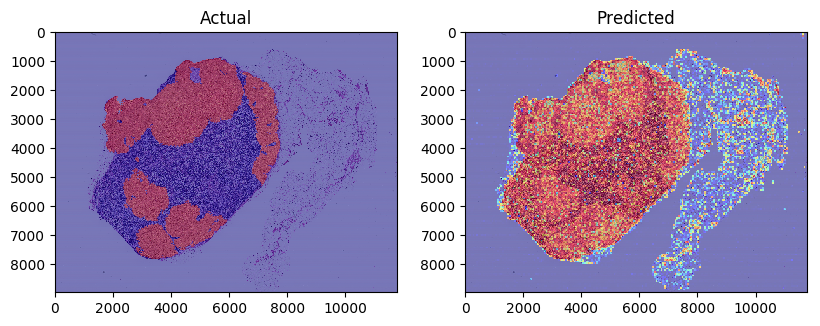

In [28]:
plt.figure(figsize = (15,12.5), dpi = 100)
plt.subplot(1,3,1)
plt.title('Actual')
plt.imshow(np.asarray(slide_test_image))
plt.imshow(np.asarray(mask_test_image), cmap = 'jet', alpha = 0.5)
plt.grid(False)

plt.subplot(1,3,2)
plt.title('Predicted')
plt.imshow(np.asarray(slide_test_image))
plt.imshow(final_mask, cmap = 'jet', alpha = 0.5) 
plt.grid(False)

## Evaluation

In [0]:
def evaluate_model(mask_image, mask_pred):
  fpr, tpr, thresholds = roc_curve(mask_image.reshape(-1).astype('float32'), mask_pred.reshape(-1), pos_label=None)
  
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.plot(fpr, tpr)
  plt.show()
  
  print('AUC : %s'%(auc(fpr, tpr)))
  
  thres = thresholds[np.argmax(1-fpr+tpr)]
  print('Threshold :', thres)
  mask_pred_labels = np.zeros(mask_pred.shape)
  mask_pred_labels[mask_pred > thres] = 1.
  
  cmat = confusion_matrix(mask_image.reshape(-1).astype('uint8'), 
                       mask_pred_labels.reshape(-1).astype('uint8'))
  
  print('CONFUSION MATRIX')
  print(cmat)
  
  tn = cmat[0][0]
  tp = cmat[1][1]
  fn = cmat[1][0]
  fp = cmat[0][1]
  
  print('True Positive : ', tp)
  print('True Negative : ', tn)
  print('False Positive : ', fp)
  print('False Negative : ', fn)
  
  precision = tp / (tp+fp)
  recall = tp / (tp+fn)
  
  print('Precision : ', precision)
  print('Recall :', recall)

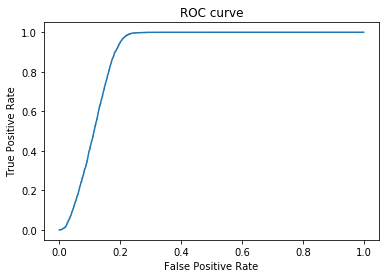

AUC : 0.885454056201899
Threshold : 0.4063341021537781
CONFUSION MATRIX
[[69306304 19757455]
 [  246256 16202945]]
True Positive :  16202945
True Negative :  69306304
False Positive :  19757455
False Negative :  246256
Precision :  0.45057744074037
Recall : 0.9850293032470088


In [30]:
evaluate_model(mask_test_image, final_mask)